In [3]:
%pylab inline
# Make default figure size bigger
matplotlib.rcParams['savefig.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = (4,3)

Populating the interactive namespace from numpy and matplotlib


## This notebook reads Henry's training file in csv format and trains a neural network

Some background on neural nets. Here we use a 2-layer neural net (see picture below). The inputs are the features. There are $D_0$ of these (As of now, $D_0 = 28$). The output is (as of now) a single node which tries to predict the last column in the spreadsheet (presumably the spread). We have the freedom to choose the dimension of the hidden layer. Right now, $D_1 = 5$. The higher it is, the more complicated functions the NN can implement, but the harder it may be to train (i.e., more local minima than aren't global minima). 

Each arrow in this drawing has a number associated with it. These are the "weights". A neuron (node) becomes activated if the nodes preceding it (weighted by the arrow weights) add up to enough. The weights after the first layer are described by a matrix of dimension $(D1,D0)$, and the weights after the second layer are described by a matrix of dimension $(1,D1)$. Actually, it's $(D1,D0+1)$ and $(1,D1+1)$ since we include a bias term at each layer.

We choose these matrices by training the neural net with known inputs and outputs. 

In [8]:
from IPython.display import Image
Image(url='https://www.otexts.org/sites/default/files/fpp/images/nnet2.png')

Now the code. First, read the data

In [9]:
fn = '/home/bhardin2/henry_NN/nnet_trainer_v2.csv'


import csv
f = open(fn,'Urb')
dat = csv.reader(f)

# Count number of training tokens (N)
# and their dimension (D0)
N = 0
for row in dat:
    N += 1
N -= 1 # don't count first row
D0 = len(row) - 1 # don't count the last parameter because it's the thing we're trying to predict
f.close()

#N = 34279
#D0 = 28

# Read the data
f = open(fn,'Urb')
dat = csv.reader(f)
Xraw = zeros((D0,N)) # Feature vectors in this matrix
Yraw = zeros((1,N))  # Output vectors (here, just scalars) in this matrix
i = 0
for row in dat:
    #print row
    if i==0:
        param_names = row[:-1]
    else:
        row_float = [float(s) for s in row]
        Xraw[:,i-1] = row_float[:-1]
        Yraw[0,i-1] = row_float[-1]
    
    i += 1

f.close()


In [10]:
print param_names

['3PA_away', '3PM_away', 'AST_away', 'BLK_away', 'FGA_away', 'FGM_away', 'FTA_away', 'FTM_away', 'OREB_away', 'PF_away', 'PTS_away', 'REB_away', 'STL_away', 'TO_away', '3PA_home', '3PM_home', 'AST_home', 'BLK_home', 'FGA_home', 'FGM_home', 'FTA_home', 'FTM_home', 'OREB_home', 'PF_home', 'PTS_home', 'REB_home', 'STL_home', 'TO_home']


Normalize the data to zero mean and unit variance

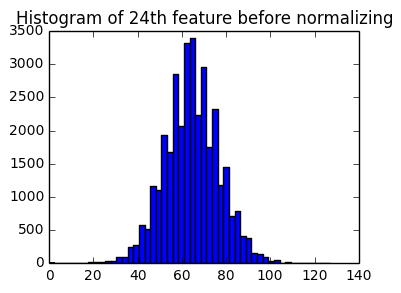

In [30]:
hist(Xraw[24,:],bins=50);
title('Histogram of 24th feature before normalizing')

In [21]:
muY = mean(Yraw)
stdY = std(Yraw)
muX = mean(Xraw,axis=1)
stdX = std(Xraw,axis=1)

Y = (Yraw-muY)/stdY
X = zeros(shape(Xraw))
for i in range(D0-1): # Leave last row as all ones
    X[i,:] = (Xraw[i,:] - muX[i])/stdX[i]

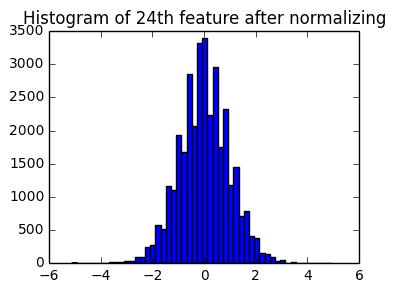

In [32]:
hist(X[24,:],bins=50);
title('Histogram of 24th feature after normalizing')

Define functions that are used to train NN

(Sorry for the lack of documentation!)

In [59]:
def tanh(x):
    '''
    Hyperbolic tangent function
    '''
    return (exp(x) - exp(-x))/(exp(x) + exp(-x))



def g(a):
    '''
    Define function that will be used as the activation function
    for each neuron in the net. For training tokens that are 
    positive and negative, a tanh function works well.
    '''
    return tanh(a)



def gp(a):
    '''
    The derivative of g(a)
    '''
    return 1 - tanh(a)**2



def nn_forward(X0,W1,W2):
    ''' Propagate the input X0 through the neural net defined by W1 and W2 '''
    
    D1,D0 = shape(W1)
    N = shape(X0)[1]
    
    # Forward propagation
    Z0 = vstack((ones((1,N)),X0))
    A1 = W1.dot(Z0)
    X1 = g(A1)
    Z1 = vstack((ones((1,N)),X1))
    A2 = W2.dot(Z1)
    X2 = g(A2)
    
    return X2



def get_gradient(X0,Y,W1,W2):
    '''
    Return the gradient of the cost function w.r.t. weight vectors W1 and W2
    '''
    N  = shape(X0)[1] # number of training tokens
    # Forward propagation
    Z0 = vstack((ones((1,N)),X0))
    A1 = W1.dot(Z0)
    X1 = g(A1)
    Z1 = vstack((ones((1,N)),X1))
    A2 = W2.dot(Z1)
    X2 = g(A2)

    # Error back propagation
    DEL2 = gp(A2) * (X2 - Y)
    DEL1 = gp(A1) * (W2[:,1:].T.dot(DEL2))

    # Calculate gradient
    gradW2 = DEL2.dot(Z1.T)
    gradW1 = DEL1.dot(Z0.T)
    
    return gradW1, gradW2



def compute_cost(X0,Y,W1,W2):
    '''
    Return the cost function of the neural net with training tokens (X0,Y) and 
    weight vectors (W1,W2)
    '''
    N  = shape(X0)[1] # number of training tokens
    # Forward propagation
    Z0 = vstack((ones((1,N)),X0))
    A1 = W1.dot(Z0)
    X1 = g(A1)
    Z1 = vstack((ones((1,N)),X1))
    A2 = W2.dot(Z1)
    X2 = g(A2)   
    cost = norm((X2-Y)/2)**2
    return cost



def optimal_step(X0,Y,W1,W2,dW1,dW2,eta_small,Nss,Rlinesearch=5):
    '''
    Take a step in the direction of dW1 and dW2, where the step is of nearly optimal length
    '''
    curr_cost = compute_cost(X0,Y,W1,W2)
    # line search to find best value of step size
    eta0 = 0
    eta1 = eta_small
    cost0 = curr_cost
    cost1 = compute_cost(X0,Y, W1+eta1*dW1, W2+eta1*dW2)
    # First make sure that the initial step is small enough
    while(cost1 >= curr_cost):
        eta1 = eta1/Rlinesearch
        cost1 = compute_cost(X0,Y, W1+eta1*dW1, W2+eta1*dW2)
        #print 'Scaling back'

    etavec = [eta0,eta1]
    costvec = [cost0,cost1]    
    while(cost1 < cost0):
        eta0 = eta1
        cost0 = cost1
        eta1 = eta0*Rlinesearch
        cost1 = compute_cost(X0,Y, W1+eta1*dW1, W2+eta1*dW2)
        #print 'eta0: %f\t eta1: %f\tcost0: %f\t cost1: %f' % (eta0, eta1, cost0, cost1)
        etavec.append(eta1)
        costvec.append(cost1)

    # Once straddled, use golden section search to find minimum
    costa = costvec[-3]
    costb = costvec[-2]
    costc = costvec[-1]
    etaa = etavec[-3]
    etab = etavec[-2]
    etac = etavec[-1]
    for iters in range(Nss):
        if etab-etaa > etac-etab: # split first interval
            etanew = (etab+etaa)/2
            costnew = compute_cost(X0,Y, W1+etanew*dW1, W2+etanew*dW2)
            if costnew < costb: # A, see notes
                etac = etab
                etab = etanew
                costc = costb
                costb = costnew
            else: # B, see notes
                etaa = etanew
                costa = costnew
        else: # split second interval
            etanew = (etab+etac)/2
            costnew = compute_cost(X0,Y, W1+etanew*dW1, W2+etanew*dW2)
            if costnew < costb: # C, see notes
                etaa = etab
                costa = costb
                etab = etanew
                costb = costnew
            else: # D, see notes
                etac = etanew
                costc = costnew

        etavec.append(etanew)
        costvec.append(costnew)
    etavec = array(etavec)
    costvec = array(costvec)
    # Finally, take step
    W1 = W1 + etab*dW1
    W2 = W2 + etab*dW2
    return W1,W2,costb,etab,etavec,costvec
    
    
    
def nn_train_cgd(X0,Y,D1,maxiters,init_rand=10.,verbose=False,Nss=10):
    '''
    Top-level function to train the neural net using conjugate gradient descent
    X0,Y: training tokens
    D1: number of hidden nodes
    init_rand: sets the magnitude of randomization for the initial guess
    verbose: whether or not to print stuff every 10th step
    Nss: how many mini-steps to use in the optimal step.
    '''
    eta_small=1e-8

    D0 = shape(X0)[0] # dimension of feature
    N  = shape(X0)[1] # number of training tokens
    # Randomize initial weights. These include the b vector in them
    W1 = init_rand/D0 * (2*(rand(D1,1+D0) - 0.5))
    W2 = init_rand/D1 * (2*(rand(1, 1+D1) - 0.5))

    W1histsave = [] # None or []
    W2histsave = []

    # First step:
    gradW1, gradW2 = get_gradient(X0,Y,W1,W2)
    dW1 = -gradW1
    dW2 = -gradW2
    W1, W2, cost, eta, etacurve, costcurve = optimal_step(X0,Y,W1,W2,dW1,dW2,eta_small,Nss)
    costvec = [cost]

    # Iterate:
    for iters in range(maxiters):
        newgradW1, newgradW2 = get_gradient(X0,Y,W1,W2)
        # Wikipedia: Polak-Ribiere beta
        numerW1 = sum(-newgradW1*(gradW1-newgradW1))
        numerW2 = sum(-newgradW2*(gradW2-newgradW2))
        denomW1 = sum(gradW1**2)
        denomW2 = sum(gradW2**2)
        beta = (numerW1 + numerW2)/(denomW1+denomW2) # should be + I think
        if beta > 0: # CG is useful
            dW1 = -newgradW1 + beta*dW1
            dW2 = -newgradW2 + beta*dW2
        else: # revert to steepest descent
            dW1 = -newgradW1
            dW2 = -newgradW2
        W1, W2, cost, eta, etacurve, costcurve = optimal_step(X0,Y,W1,W2,dW1,dW2,eta_small,Nss)
        costvec.append(cost)
        gradW1 = newgradW1
        gradW2 = newgradW2
        W1histsave.append(W1)
        W2histsave.append(W2)
        if verbose and mod(iters,10)==0:
            print 'Iter %03i\t Beta: %4.8f\tCost: %5.2f\t Step: %.10f' % (iters, beta, cost, eta)
            
    return W1,W2,costvec,W1histsave,W2histsave
    

Split data up into training and test sets. For now, use odd-numbered tokens to train, and even-numbered to test.

In [60]:
idx = arange(N)
train_idx = (idx%2 == 0)
test_idx = ~train_idx

In [61]:
Xtrain = X[:,train_idx]
Xtest = X[:,test_idx]
Ytrain = Y[:,train_idx]
Ytest = Y[:,test_idx]

Ntrain = sum(train_idx)
Ntest = sum(test_idx)

In [62]:
# Run CGD
D1 = 5 # Number of hidden nodes. We can optimize this later.
maxiters = 1000 # when to stop. (There are more intelligent ways of stopping, but this works for now)
verbose = True # whether to print stuff to watch it converge

W1,W2,costvec,W1hist,W2hist = nn_train_cgd(Xtrain, Ytrain, D1, maxiters, verbose=verbose)

Iter 000	 Beta: 0.01898169	Cost: 1583.15	 Step: 0.0001660156
Iter 010	 Beta: 0.42605197	Cost: 938.26	 Step: 0.0000296875
Iter 020	 Beta: 0.34852028	Cost: 898.49	 Step: 0.0000625000
Iter 030	 Beta: 1.14787905	Cost: 888.42	 Step: 0.0000488281
Iter 040	 Beta: 1.59376546	Cost: 881.86	 Step: 0.0000332031
Iter 050	 Beta: 1.27281697	Cost: 876.30	 Step: 0.0000449219
Iter 060	 Beta: 0.74757571	Cost: 872.25	 Step: 0.0000281250
Iter 070	 Beta: 0.68355157	Cost: 869.66	 Step: 0.0000332031
Iter 080	 Beta: 0.68059353	Cost: 866.47	 Step: 0.0000390625
Iter 090	 Beta: 0.64560202	Cost: 862.84	 Step: 0.0000429687
Iter 100	 Beta: 0.47577693	Cost: 860.14	 Step: 0.0000585937
Iter 110	 Beta: 0.63887306	Cost: 856.51	 Step: 0.0000332031
Iter 120	 Beta: 1.21352656	Cost: 854.08	 Step: 0.0000400391
Iter 130	 Beta: 1.12804620	Cost: 851.10	 Step: 0.0000281250
Iter 140	 Beta: 1.63570035	Cost: 846.50	 Step: 0.0000585937
Iter 150	 Beta: 0.90338637	Cost: 838.04	 Step: 0.0001093750
Iter 160	 Beta: 0.62786807	Cost: 832.05

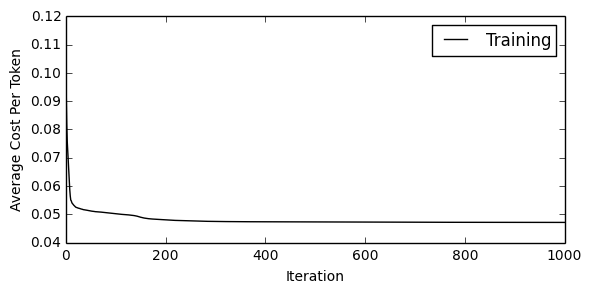

In [63]:
figure(figsize=(6,3))
costvec = array(costvec)
plot(costvec/Ntrain,'k-',label='Training')
xlabel('Iteration')
ylabel('Average Cost Per Token')
legend(loc='best')
tight_layout()

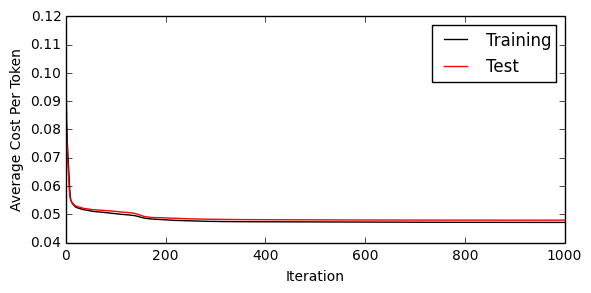

In [64]:
figure(figsize=(6,3))
testcostvec = []
for i in range(len(W1hist)):
    W1h = W1hist[i]
    W2h = W2hist[i]
    testcostvec.append(compute_cost(Xtest,Ytest,W1h,W2h))
testcostvec = array(testcostvec)
costvec = array(costvec)
plot(costvec/Ntrain,'k-',label='Training')
plot(testcostvec/Ntest,'r-',label='Test')
xlabel('Iteration')
ylabel('Average Cost Per Token')
legend(loc='best')
tight_layout()

What's the best way to see how well it did? How do we quantify performance?